In [1]:
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from model import Generator
from util import *

plt.rcParams['figure.dpi'] = 150

# Controllable Toonification

- face.pt https://drive.google.com/uc?id=1dOBo4xWUwM7-BwHWZgp-kV1upaD6tHAh
- disney.pt https://drive.google.com/uc?id=1n2uQ5s2XdUBGIcZA9Uabz1mkjVvKWFeG

In [2]:
device = 'cpu' #@param ['cuda', 'cpu']

generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

mean_latent1 = load_model(generator1, 'face.pt')
mean_latent2 = load_model(generator2, 'disney.pt')

print(len(mean_latent1))
print(mean_latent1[0].shape)

20
torch.Size([1, 512])


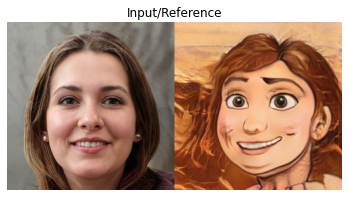

In [90]:
truncation = .5
face_seed =  44614 #@param {type:"number"} 
disney_seed =  11312 #@param {type:"number"} 
    
with torch.no_grad():
    torch.manual_seed(face_seed)
    source_code = torch.randn([1, 512]).to(device)
    latent1 = generator1.get_latent(source_code, truncation=truncation, mean_latent=mean_latent1)
    source_im, _ = generator1(latent1)

    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    display_image(torch.cat([source_im, reference_im], -1), size=None, title='Input/Reference')

## Toonify input face using the reference disney face

- num_swap: determines how many early layers to borrow from input image. This controls how much structure to borrow from input image.
- alpha: controls the degree of toonification.

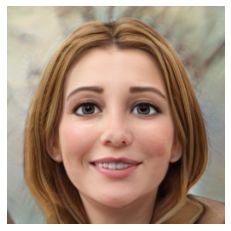

In [85]:
# num_swap 이 크면 실사에 가까운 이미지가 나옴. basic : 6, max:20
num_swap =  6
alpha =  0.5

early_alpha = 0

def toonify(latent1, latent2):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image

result = toonify(latent1, latent2)
display_image(result)

## Real World Image

- https://mobile.newsis.com/view.html?ar_id=NISX20211028_0001631529

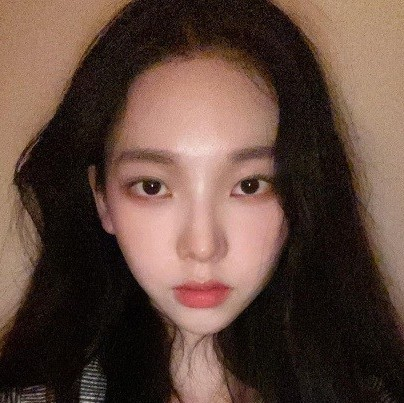

In [45]:
from PIL import Image

Image.open('imgs/01.jpg')

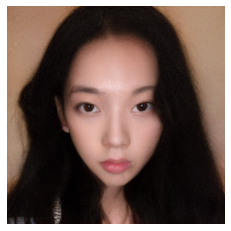

In [46]:
latent_real = torch.load('inversion_codes/01.pt', map_location=torch.device('cpu'))['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

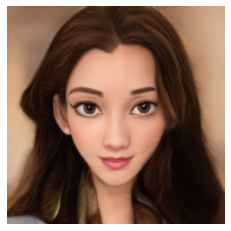

In [47]:
result2 = toonify(latent_real, latent2)

display_image(result2)

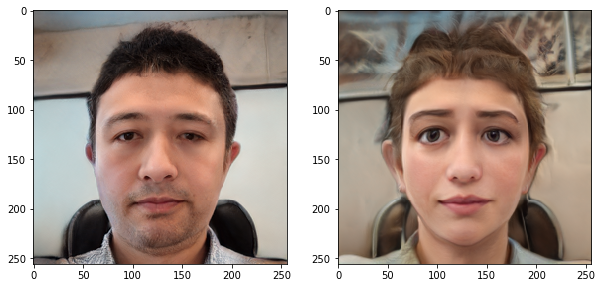

In [86]:
resultImages = []
latent_real = torch.load('inversion_codes/f1.pt', map_location=torch.device('cpu'))['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

resultImages.append(display_image_return(source_im))

result2 = toonify(latent_real, latent2)

resultImages.append(display_image_return(result2))

f, axarr = plt.subplots(1,2, figsize=(10, 5))
img = resultImages[0]
axarr[0].imshow(img, interpolation='none', cmap='Blues')
img = resultImages[1]
axarr[1].imshow(img, interpolation='none', cmap='Blues')

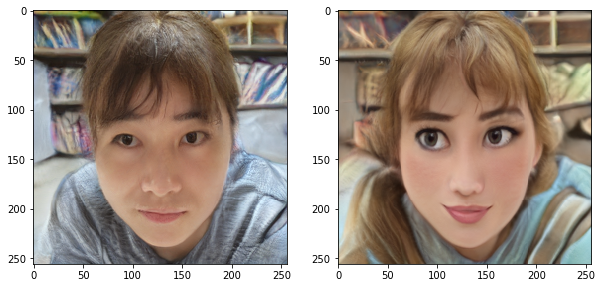

In [87]:
resultImages = []
latent_real = torch.load('inversion_codes/f2.pt', map_location=torch.device('cpu'))['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

resultImages.append(display_image_return(source_im))

result2 = toonify(latent_real, latent2)

resultImages.append(display_image_return(result2))

f, axarr = plt.subplots(1,2, figsize=(10, 5))
img = resultImages[0]
axarr[0].imshow(img, interpolation='none', cmap='Blues')
img = resultImages[1]
axarr[1].imshow(img, interpolation='none', cmap='Blues')

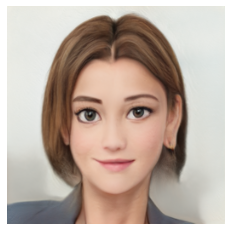

In [69]:
display_image(result2)

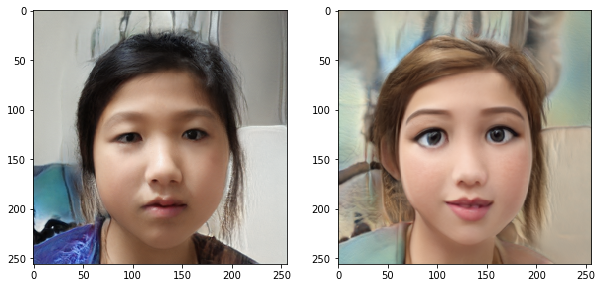

In [88]:
resultImages = []
latent_real = torch.load('inversion_codes/f3.pt', map_location=torch.device('cpu'))['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

resultImages.append(display_image_return(source_im))

result2 = toonify(latent_real, latent2)

resultImages.append(display_image_return(result2))

f, axarr = plt.subplots(1,2, figsize=(10, 5))
img = resultImages[0]
axarr[0].imshow(img, interpolation='none', cmap='Blues')
img = resultImages[1]
axarr[1].imshow(img, interpolation='none', cmap='Blues')

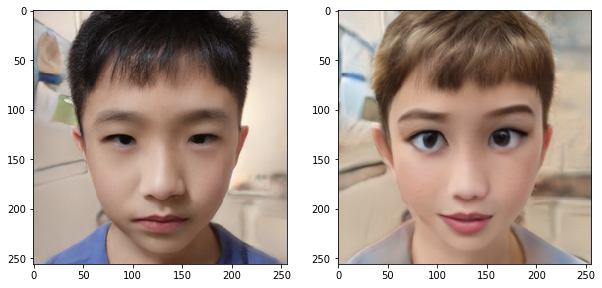

In [89]:
resultImages = []
latent_real = torch.load('inversion_codes/f4.pt', map_location=torch.device('cpu'))['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

resultImages.append(display_image_return(source_im))

result2 = toonify(latent_real, latent2)

resultImages.append(display_image_return(result2))

f, axarr = plt.subplots(1,2, figsize=(10, 5))
img = resultImages[0]
axarr[0].imshow(img, interpolation='none', cmap='Blues')
img = resultImages[1]
axarr[1].imshow(img, interpolation='none', cmap='Blues')

## Local Image Translation

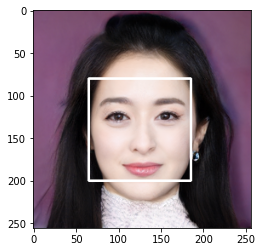

In [63]:
import cv2

rect_img = tensor2image(source_im).copy()

x, y, w, h = 65, 80, 120, 120

cv2.rectangle(rect_img, pt1=(x, y), pt2=(x+w, y+h), thickness=2, color=(255, 255, 255))

plt.imshow(rect_img)

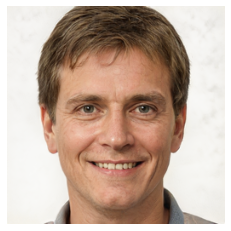

In [15]:
reference_im, _ = generator1(latent2)

display_image(reference_im)

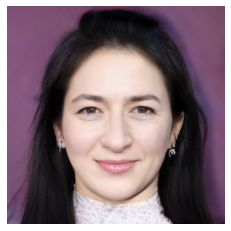

In [16]:
with torch.no_grad():
    blend = generator1.blend_bbox(latent_real, latent2, [(x, y, w, h)], model_type='face', num_blend=10)

display_image(blend)

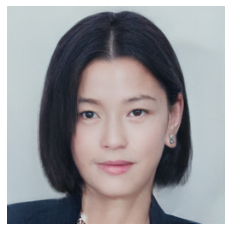

In [17]:
latent_real06 = torch.load('inversion_codes/jiheoun_06.pt', map_location=torch.device('cpu'))['latent']
latent_real06 = style2list(latent_real06)

source_im06, _06 = generator1(latent_real06)

display_image(source_im06)

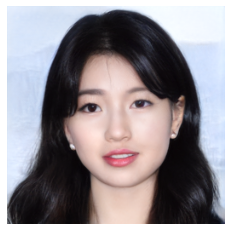

In [18]:
latent_real05 = torch.load('inversion_codes/suzy_05.pt', map_location=torch.device('cpu'))['latent']
latent_real05 = style2list(latent_real05)

source_im05, _05 = generator1(latent_real05)

display_image(source_im05)